In [ ]:
import os
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import scipy.stats
import statsmodels.stats.multitest as smm

# Load data

## Load Somatodendritic morphology data

In [ ]:
# Define the folder path containing the Excel files
data_directory_path = r'../data/morphology/quantitative_analysis'

# Lists to collect metrics, cell numbers, and Feret data
metrics_columns = ['soma_length', 'soma_mean_length', 'soma_area', 'soma_mean_area', 
                   'soma_surface', 'soma_volume', 'dendrites_num_primary', 
                   'dendrites_length_all', 'dendrites_length_mean', 
                   'dendrites_surface_all', 'dendrites_surface_mean', 
                   'dendrites_volume_all', 'dendrites_volume_mean', 
                   'dendrites_complexity', 'dendrites_nodes_num', 
                   'dendrites_ends_num', 'dendrites_length_by_order', 
                   'dendrites_max_order', 'dendrites_max_order_by_tree',
                   'feret_area', 'feret_max', 'feret_min', 'roundness']
data_dict = {col: [] for col in metrics_columns}
data_dict['Cell_Num'] = []

# Walk through the folder to find Excel files
for (_, _, filenames) in os.walk(data_directory_path):
    for filename in filenames:
        if filename.endswith('.xlsx'):
            
            # Extract cell number from filename
            cell_num = int(filename.split('_')[-1].split('.')[0])
            data_dict['Cell_Num'].append(cell_num)

            # Define the full file path
            fname = os.path.join(data_directory_path, filename)

            # Load data from Excel Neurolucida output
            neuron_summary = pd.read_excel(fname, sheet_name='Neuron Summary')
            dendrites = pd.read_excel(fname, sheet_name='Each Tree - Dendrites')

            # Metrics extraction
            soma_length = neuron_summary[neuron_summary['Name'] == 'Cell Body']['Length(µm)'].iloc[0]
            soma_mean_length = neuron_summary[neuron_summary['Name'] == 'Cell Body']['Mean Length'].iloc[0]
            soma_area = neuron_summary[neuron_summary['Name'] == 'Cell Body']['Area (µm²)'].iloc[0]
            soma_mean_area = neuron_summary[neuron_summary['Name'] == 'Cell Body']['Mean Area'].iloc[0]
            soma_surface = neuron_summary[neuron_summary['Name'] == 'Cell Body']['Surface(µm²)'].iloc[0]
            soma_volume = neuron_summary[neuron_summary['Name'] == 'Cell Body']['Volume(µm³)'].iloc[0]
            dendrites_num_primary = neuron_summary[neuron_summary['Name'] == 'Dendrite']['Qty'].iloc[0]
            dendrites_length_all = neuron_summary[neuron_summary['Name'] == 'Dendrite']['Length(µm)'].iloc[0]
            dendrites_length_mean = neuron_summary[neuron_summary['Name'] == 'Dendrite']['Mean Length'].iloc[0]
            dendrites_surface_all = neuron_summary[neuron_summary['Name'] == 'Dendrite']['Surface(µm²)'].iloc[0]
            dendrites_surface_mean = neuron_summary[neuron_summary['Name'] == 'Dendrite']['Mean Surface'].iloc[0]
            dendrites_volume_all = neuron_summary[neuron_summary['Name'] == 'Dendrite']['Volume(µm³)'].iloc[0]
            dendrites_volume_mean = neuron_summary[neuron_summary['Name'] == 'Dendrite']['Mean Volume'].iloc[0]
            dendrites_complexity = neuron_summary[neuron_summary['Name'] == 'Dendrite']['Complexity'].iloc[0]
            dendrites_max_order_by_tree = dendrites.groupby(by='Tree').Order.max()
            dendrites_nodes_num = neuron_summary[neuron_summary['Name'] == 'Dendrite']['Nodes'].iloc[0]
            dendrites_ends_num = neuron_summary[neuron_summary['Name'] == 'Dendrite']['Ends'].iloc[0]
            dendrites_length_by_order = dendrites.groupby(['Order'])['Length Total(µm)'].sum()
            dendrites_max_order = dendrites.Order.max()

            # Additional step to load and process Feret data
            feret_data = pd.read_excel(fname, sheet_name='Cell Body Contours')
            feret_data.dropna(inplace=True)
            feret_data = feret_data[['Area(µm²)', 'Feret Max(µm)', 'Feret Min(µm)', 'Roundness']]
            feret_data = feret_data.loc[feret_data['Area(µm²)'].idxmax()]

            # Add Feret data to the metrics
            feret_area, feret_max, feret_min, roundness = feret_data['Area(µm²)'], feret_data['Feret Max(µm)'], feret_data['Feret Min(µm)'], feret_data['Roundness']

            # Store the metrics in the dictionary
            metrics_values = [soma_length, soma_mean_length, soma_area, soma_mean_area, soma_surface, 
                              soma_volume, dendrites_num_primary, dendrites_length_all, dendrites_length_mean, 
                              dendrites_surface_all, dendrites_surface_mean, dendrites_volume_all, 
                              dendrites_volume_mean, dendrites_complexity, dendrites_nodes_num, dendrites_ends_num,
                              dendrites_length_by_order, dendrites_max_order, dendrites_max_order_by_tree,
                              feret_area, feret_max, feret_min, roundness]

            for col, value in zip(metrics_columns, metrics_values):
                data_dict[col].append(value)

# Create a DataFrame from the collected data
data_morphology = pd.DataFrame(data_dict)
data_morphology = data_morphology[['Cell_Num'] + [col for col in data_morphology.columns if col != 'Cell_Num']] # Reorder columns

## Add TH label

In [ ]:
# Load electrophysiology data so that we can take the TH_label column
from analysis_utils import load_json_restore_arrays

data_electrophysiology = load_json_restore_arrays('../data/data_electrophysiology.json')
data_electrophysiology = data_electrophysiology[['TH_label', 'Cell_Num']]
data = pd.merge(data_morphology, data_electrophysiology, on='Cell_Num', how='inner')
data = data[['Cell_Num', 'TH_label'] + [col for col in data.columns if col not in ['Cell_Num', 'TH_label']]] # Reorder columns

## Load Scholl Analysis data

In [ ]:
# Define the path to the directory containing the Excel files
data_directory_path = '../data/morphology/quantitative_analysis'

# Initialize an empty DataFrame to store aggregated data
aggregated_data = pd.DataFrame([])

# List all Excel files in the specified directory
excel_file_paths = [file_name for file_name in os.listdir(data_directory_path) if file_name.endswith('.xlsx')]

for excel_file_name in excel_file_paths:
    full_file_path = os.path.join(data_directory_path, excel_file_name)
    
    # Extract the cell number from the file name
    cell_number = int(excel_file_name.split('_')[-1].split('.')[0])

    # Load Sholl analysis data from the 'Sholl - Dendrites' sheet
    dendrite_data = pd.read_excel(full_file_path, sheet_name='Sholl - Dendrites')
    
    # Remove columns related to spine analysis, not needed
    dendrite_data.drop(columns=['Spines', 'None Spine', 'Thin Spine', 'Stubby Spine', 'Mushroom Spine',
                                'Filipodia Spine', 'Branched Spine', 'Detached Spine', 'Other Spine', 
                                'Automatic Varicosities'], inplace=True)
    
    dendrite_data.rename(columns={"SArea(µm²)": "Surface_Area(µm²)"}, errors="raise", inplace=True)
    
    # Add cell number to the data
    dendrite_data['Cell_Num'] = cell_number
    dendrite_data.dropna(inplace=True)

    # Ensure 'Radius(µm)' column is treated as numeric to facilitate joining
    dendrite_data['Radius(µm)'] = pd.to_numeric(dendrite_data['Radius(µm)'], errors='coerce')

    # Load branch order data from the 'Sholl Branch Order - Dendrites' sheet
    branch_order_data = pd.read_excel(full_file_path, sheet_name='Sholl Branch Order - Dendrites')
    
    # Ensure 'Radius(µm)' column in branch order data is numeric
    branch_order_data['Radius(µm)'] = pd.to_numeric(branch_order_data['Radius(µm)'], errors='coerce')

    # Merge dendrite data with branch order data based on 'Radius(µm)'
    dat = dendrite_data.set_index('Radius(µm)').join(branch_order_data.set_index('Radius(µm)')).reset_index()
    
    # add to merged data
    aggregated_data = pd.concat([aggregated_data, dat])

In [ ]:
# Find the cell with the largest radius, and pad the rest
cell_nums = np.unique(aggregated_data['Cell_Num'].values)

radius_len = 0
radius_largest = np.array([])
cell_num_largest = ''

for cell_num in cell_nums:
    df_cell = aggregated_data[aggregated_data['Cell_Num']==cell_num]
    if df_cell.shape[0] > radius_len:
        cell_num_largest = cell_num
        radius_largest = df_cell['Radius(µm)'].values
        radius_len = df_cell.shape[0]

print('This is the cell largest radius: {}'.format(cell_num_largest))
print('This is the largest radius: {}'.format(np.max(radius_largest)))

This is the cell largest radius: 38
This is the largest radius: 810.0


In [ ]:
# Format Scholl data
df = aggregated_data

cellIDs = []
neurochem_ids = []
radia = []
intersections = []
lengths = []
areas = []
volumes = []
diameters = []
nodes = []
endings = []
order_1 = []
order_2 = []
order_3 = []
order_4 = []
order_5 = []
order_6 = []
order_7 = []
order_8 = []
order_9 = []
order_10 = []
order_11 = []
intersects_order_1 = []
intersects_order_2 = []
intersects_order_3 = []
intersects_order_4 = []
intersects_order_5 = []
intersects_order_6 = []
intersects_order_7 = []
intersects_order_8 = []
intersects_order_9 = []
intersects_order_10 = []
intersects_order_11 = []

unique_cellIDs = np.unique(df['Cell_Num'].values)
cellIDs = []
for cellID in unique_cellIDs:

    df_cell = df[df['Cell_Num']==cellID]
    pad_len = radius_largest.shape[0]-df_cell.shape[0]

    cellIDs.append(cellID)
    intersections.append(np.concatenate([df_cell['Intersections'].values, np.zeros(pad_len,)]))
    lengths.append(np.concatenate([df_cell['Length(µm)'].values, np.zeros(pad_len,)]))
    areas.append(np.concatenate([df_cell['Surface_Area(µm²)'].values, np.zeros(pad_len,)]))
    volumes.append(np.concatenate([df_cell['Volume(µm³)'].values, np.zeros(pad_len,)]))
    diameters.append(np.concatenate([df_cell['Avg. Diameter(µm)'].values, np.zeros(pad_len,)]))
    nodes.append(np.concatenate([df_cell['Nodes'].values, np.zeros(pad_len,)]))
    endings.append(np.concatenate([df_cell['Endings'].values, np.zeros(pad_len,)]))
    order_1.append(np.concatenate([df_cell['Order 1(µm)'].values, np.zeros(pad_len,)]))
    order_2.append(np.concatenate([df_cell['Order 2(µm)'].values, np.zeros(pad_len,)]))
    order_3.append(np.concatenate([df_cell['Order 3(µm)'].values, np.zeros(pad_len,)]))
    order_4.append(np.concatenate([df_cell['Order 4(µm)'].values, np.zeros(pad_len,)]))
    order_5.append(np.concatenate([df_cell['Order 5(µm)'].values, np.zeros(pad_len,)]))
    order_6.append(np.concatenate([df_cell['Order 6(µm)'].values, np.zeros(pad_len,)]))
    order_7.append(np.concatenate([df_cell['Order 7(µm)'].values, np.zeros(pad_len,)]))
    order_8.append(np.concatenate([df_cell['Order 8(µm)'].values, np.zeros(pad_len,)]))
    order_9.append(np.concatenate([df_cell['Order 9(µm)'].values, np.zeros(pad_len,)]))
    order_10.append(np.concatenate([df_cell['Order 10(µm)'].values, np.zeros(pad_len,)]))
    order_11.append(np.concatenate([df_cell['Order 11(µm)'].values, np.zeros(pad_len,)]))
    intersects_order_1.append(np.concatenate([df_cell['Intersections - Order 1'].values, np.zeros(pad_len,)]))
    intersects_order_2.append(np.concatenate([df_cell['Intersections - Order 2'].values, np.zeros(pad_len,)]))
    intersects_order_3.append(np.concatenate([df_cell['Intersections - Order 3'].values, np.zeros(pad_len,)]))
    intersects_order_4.append(np.concatenate([df_cell['Intersections - Order 4'].values, np.zeros(pad_len,)]))
    intersects_order_5.append(np.concatenate([df_cell['Intersections - Order 5'].values, np.zeros(pad_len,)]))
    intersects_order_6.append(np.concatenate([df_cell['Intersections - Order 6'].values, np.zeros(pad_len,)]))
    intersects_order_7.append(np.concatenate([df_cell['Intersections - Order 7'].values, np.zeros(pad_len,)]))
    intersects_order_8.append(np.concatenate([df_cell['Intersections - Order 8'].values, np.zeros(pad_len,)]))
    intersects_order_9.append(np.concatenate([df_cell['Intersections - Order 9'].values, np.zeros(pad_len,)]))
    intersects_order_10.append(np.concatenate([df_cell['Intersections - Order 10'].values, np.zeros(pad_len,)]))
    intersects_order_11.append(np.concatenate([df_cell['Intersections - Order 11'].values, np.zeros(pad_len,)]))


    df_ = pd.DataFrame(dict(Cell_Num = cellIDs,                        
                            intersection = intersections,
                            length = lengths,
                            area = areas,
                            volume = volumes,
                            diameter = diameters,
                            nodes = nodes,
                            endings = endings,
                            order_1 = order_1,
                            order_2 = order_2,
                            order_3 = order_3,
                            order_4 = order_4,
                            order_5 = order_5,
                            order_6 = order_6,
                            order_7 = order_7,
                            order_8 = order_8,
                            order_9 = order_9,
                            order_10 = order_10,
                            order_11 = order_11,
                            intersects_order_1 = intersects_order_1,
                            intersects_order_2 = intersects_order_2,
                            intersects_order_3 = intersects_order_3,
                            intersects_order_4 = intersects_order_4,
                            intersects_order_5 = intersects_order_5,
                            intersects_order_6 = intersects_order_6,
                            intersects_order_7 = intersects_order_7,
                            intersects_order_8 = intersects_order_8,
                            intersects_order_9 = intersects_order_9,
                            intersects_order_10 = intersects_order_10,
                            intersects_order_11 = intersects_order_11))
    
data_scholl = df_.merge(data_electrophysiology[['Cell_Num', 'TH_label']], on='Cell_Num', how='left')
data_scholl = data_scholl[['Cell_Num', 'intersection', 'TH_label']]

Perform Statistics

In [ ]:
# Define the list of features to test
features = ['dendrites_nodes_num', 'feret_min', 'dendrites_complexity']  # Features

p_values = {}
for feature in features:
    x1 = data[data['TH_label'] == 'pos'][feature].dropna().to_numpy()
    x2 = data[data['TH_label'] == 'neg'][feature].dropna().to_numpy()
    
    stats, p = scipy.stats.mannwhitneyu(x=x1, y=x2)
    p = np.round(p, 3) 
    p_values[feature] = '{}'.format(p)  

# Print the results
for i, feature in enumerate(features):
    
    formatted_pval = p_values.get(feature)
    
    # Recalculate x1 and x2 to get counts
    x1 = data[data['TH_label'] == 'pos'][feature].dropna().to_numpy()
    x2 = data[data['TH_label'] == 'neg'][feature].dropna().to_numpy()
    
    # Calculate mean and standard deviation for pos and neg
    mean_x1 = np.round(np.mean(x1), 2)
    std_x1 = np.round(np.std(x1, ddof=1), 2)
    mean_x2 = np.round(np.mean(x2), 2)
    std_x2 = np.round(np.std(x2, ddof=1), 2)
    
    print(f'Feature: {feature}')
    print('N_pos =', len(x1))
    print('N_neg =', len(x2))
    print('Mean±std (pos): {} ± {}'.format(mean_x1, std_x1))
    print('Mean±std (neg): {} ± {}'.format(mean_x2, std_x2))
    print('P-value:', formatted_pval)
    print('---')

Feature: dendrites_nodes_num
N_pos = 13
N_neg = 11
Mean±std (pos): 11.54 ± 6.12
Mean±std (neg): 23.09 ± 23.07
P-value: 0.181
---
Feature: feret_min
N_pos = 13
N_neg = 11
Mean±std (pos): 12.59 ± 2.51
Mean±std (neg): 12.9 ± 4.28
P-value: 0.817
---
Feature: dendrites_complexity
N_pos = 13
N_neg = 11
Mean±std (pos): 46323.67 ± 38374.28
Mean±std (neg): 134840.35 ± 211674.75
P-value: 0.132
---


# Plotting

In [ ]:
colors = ['#7570b3', '#1b9e77']
plt.rcParams['svg.fonttype'] = 'none'

In [ ]:
df_pos = data[data['TH_label'] == 'pos']
df_neg = data[data['TH_label'] == 'neg']

### Figure S3B: Scholl analysis

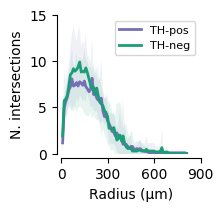

In [ ]:
# Extract mean and std/sem for each cell class

features_pos = np.stack(data_scholl[data_scholl['TH_label'] == 'pos']['intersection'].to_numpy()).astype(np.float64)
feature_pos_mean = np.mean(features_pos, axis=0)
feature_pos_std = np.std(features_pos, axis=0)
#feature_pos_sem = scipy.stats.sem(features_pos, axis=0)


features_neg = np.stack(data_scholl[data_scholl['TH_label'] == 'neg']['intersection'].to_numpy()).astype(np.float64)
feature_neg_mean = np.mean(features_neg, axis=0)
feature_neg_std = np.std(features_neg, axis=0)
#feature_neg_sem = scipy.stats.sem(features_neg, axis=0)

# Make the Figure

fig, ax = plt.subplots(1,1,figsize=(1.8,1.8))

x = np.arange(10, 820, 10, dtype=float); #x = np.array(radius_largest, dtype=float)
ax.plot(x, feature_pos_mean, color=colors[0], lw=2, label='TH-pos')
ax.plot(x, feature_neg_mean, color=colors[1], lw=2, label='TH-neg')

ax.fill_between(x, feature_neg_mean-feature_neg_std, feature_neg_mean+feature_neg_std, edgecolor='none', facecolor=colors[0], alpha=.1)
ax.fill_between(x, feature_pos_mean-feature_pos_std, feature_pos_mean+feature_pos_std, edgecolor='none', facecolor=colors[1], alpha=.1)
#ax.fill_between(x, feature_neg_mean-feature_neg_sem, feature_neg_mean+feature_neg_sem, edgecolor='none', facecolor=colors[0], alpha=.1)
#ax.fill_between(x, feature_pos_mean-feature_pos_sem, feature_pos_mean+feature_pos_sem, edgecolor='none', facecolor=colors[1], alpha=.1)

ax.legend(fontsize=8, frameon=True)
ax.set_xlabel('Radius (μm)')
ax.set_ylabel('N. intersections')
ax.set_ylim(0, 15)
ax.set_xlim(0, 900)
ax.set_xticks([0, 300, 600, 900])

fig.patch.set_facecolor('white')

sns.despine(offset=3,trim=True)

fig.savefig('../plots/morpho_scholl_intersections.png', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
#fig.savefig('../plots/morpho_scholl_intersections.svg', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

### Figure S3C: Number of dendritic nodes

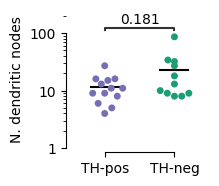

In [ ]:
feature = 'dendrites_nodes_num'
formatted_pvals_plot = [p_values.get(feature)]

fig, ax = plt.subplots(1,1,figsize=(1.8,1.8))

sns.swarmplot(data=data,
             x='TH_label',
             y=feature,
             palette=colors,
             order=['pos', 'neg'],
             ax=ax)

ax.plot([-.2, .2], [np.mean(df_pos[feature].values), np.mean(df_pos[feature].values)], color='k')
ax.plot([.8, 1.2], [np.mean(df_neg[feature].values), np.mean(df_neg[feature].values)], color='k')

ax.set_xlabel('')
ax.set_xticklabels(['TH-pos', 'TH-neg'], fontsize=8)
ax.set_ylabel('N. dendritic nodes')

ax.set_yscale('log')
ax.set_ylim(1, 100)
ax.set_yticks([1, 10, 100])
ax.set_yticklabels([1, 10, 100])

# Stats annotations
annotator = Annotator(data=data,
                      x='TH_label',
                      y=feature,
                      pairs=[('pos','neg')],
                      order=None, 
                      orient='v',
                      short_test_name=False,
                      ax=ax,
                      verbose=False
                      )
annotator.set_custom_annotations(formatted_pvals_plot)
annotator.annotate()
annotator.configure(loc='outside', fontsize=8, line_width=1)
    
sns.despine(offset=3,trim=True)

fig.patch.set_facecolor('white') # type: ignore

fig.savefig('../plots/morpho_dendritic_nodes.png', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
#fig.savefig('../plots/morpho_dendritic_nodes.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

### Figure S3D: Soma Minimum Feret Diameter

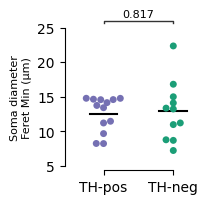

In [ ]:
feature = 'feret_min'

formatted_pvals_plot = [p_values.get(feature)]

fig, ax = plt.subplots(1,1,figsize=(1.8, 1.8))

df_pos = data[data['TH_label']=='pos']
df_neg = data[data['TH_label']=='neg']

ax.plot([-.2, .2], [np.mean(df_pos[feature].values), np.mean(df_pos[feature].values)], color='k')
ax.plot([.8, 1.2], [np.mean(df_neg[feature].values), np.mean(df_neg[feature].values)], color='k')

sns.swarmplot(data=data,
             x='TH_label',
             y=feature,
             palette=colors,
             ax=ax,
             order=['pos', 'neg'])

ax.set_xlabel('')
ax.set_xticklabels(['TH-pos', 'TH-neg'], fontsize=8)
ax.set_ylabel('Soma diameter\nFeret Min (µm)', fontsize=8)
ax.set_ylim([5,25])
ax.set_yticks([5,10,15,20,25])

# Stats annotations
annotator = Annotator(data=data,
                      x='TH_label',
                      y=feature,
                      pairs=[('pos','neg')],
                      order=None, 
                      orient='v',
                      short_test_name=False,
                      ax=ax,
                      verbose=False
                      )
annotator.configure(loc='outside', fontsize=8, line_width=1)
annotator.set_custom_annotations(formatted_pvals_plot)
annotator.annotate()
    
sns.despine(offset=3,trim=True)

fig.patch.set_facecolor('white')

fig.savefig('../plots/morpho_feret_min.png', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
#fig.savefig('../plots/morpho_feret_min.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

### Figure S3E: Complexity

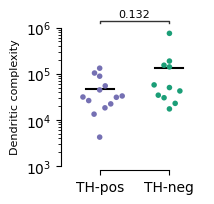

In [ ]:
feature = 'dendrites_complexity'

formatted_pvals_plot = [p_values.get(feature)]

fig, ax = plt.subplots(1,1,figsize=(1.8,1.8))

df_pos = data[data['TH_label']=='pos']
df_neg = data[data['TH_label']=='neg']

sns.swarmplot(data=data,
             x='TH_label',
             y=feature,
             palette=colors,
             order=['pos', 'neg'],
             ax=ax,
             size=4
             )
ax.plot([-.2, .2], [np.mean(df_pos[feature].values), np.mean(df_pos[feature].values)], color='k')
ax.plot([.8, 1.2], [np.mean(df_neg[feature].values), np.mean(df_neg[feature].values)], color='k')

ax.set_xlabel('')
ax.set_xticklabels(['TH-pos', 'TH-neg'], fontsize=8)
ax.set_ylabel('Dendritic complexity', fontsize=8)
#logy
ax.set_yscale('log')
ax.set_ylim(1000, 1000000)
ax_set_yticks = [1000, 10000, 100000, 1000000]

# Stats annotations
annotator = Annotator(data=data,
                      x='TH_label',
                      y=feature,
                      pairs=[('pos','neg')],
                      order=None, 
                      orient='v',
                      short_test_name=False,
                      ax=ax,
                      verbose=False
                      )
annotator.configure(loc='outside', fontsize=8, line_width=1)
annotator.set_custom_annotations(formatted_pvals_plot)
annotator.annotate()
    
sns.despine(offset=3,trim=True)

fig.patch.set_facecolor('white')

fig.savefig('../plots/morpho_dendritic_complexity.png', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
#fig.savefig('../plots/morpho_dendritic_complexity.svg', bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)